In [1]:
import pydot
import matplotlib.pyplot as plt
import time
import math
import random
from sklearn.manifold import MDS
import numpy as np
import plotly.graph_objs as go
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap

nodes [<pydot.core.Node object at 0x14e84b550>, <pydot.core.Node object at 0x14d3937d0>, <pydot.core.Node object at 0x14e84a4d0>, <pydot.core.Node object at 0x14d3dbf10>, <pydot.core.Node object at 0x14d3d8390>, <pydot.core.Node object at 0x14e3151d0>, <pydot.core.Node object at 0x14e4851d0>, <pydot.core.Node object at 0x14d74db50>, <pydot.core.Node object at 0x14e43b950>, <pydot.core.Node object at 0x14d364e50>, <pydot.core.Node object at 0x14ea4c190>, <pydot.core.Node object at 0x14e4a9790>, <pydot.core.Node object at 0x14e5715d0>, <pydot.core.Node object at 0x14e746cd0>, <pydot.core.Node object at 0x14e7466d0>, <pydot.core.Node object at 0x14e737a50>]
edges [<pydot.core.Node object at 0x14e84b550>, <pydot.core.Node object at 0x14d3937d0>, <pydot.core.Node object at 0x14e84a4d0>, <pydot.core.Node object at 0x14d3dbf10>, <pydot.core.Node object at 0x14d3d8390>, <pydot.core.Node object at 0x14e3151d0>, <pydot.core.Node object at 0x14e4851d0>, <pydot.core.Node object at 0x14d74db50>, <p

/var/folders/pp/bdyt1jrd5w5d3twfkg227dtc0000gn/T/ipykernel_41076/2364825144.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  similarities[i, j] = 1 / (1 + distances[i, j])


Iteration 1: KL divergence = 0.30753594636917114
Iteration 2: KL divergence = 0.30753594636917114
Iteration 3: KL divergence = 0.30753594636917114
Iteration 4: KL divergence = 0.30753594636917114
Iteration 5: KL divergence = 0.30753594636917114
Iteration 6: KL divergence = 0.30753594636917114
Iteration 7: KL divergence = 0.30753594636917114
Iteration 8: KL divergence = 0.30753594636917114
Iteration 9: KL divergence = 0.30753594636917114
Iteration 10: KL divergence = 0.30753594636917114
Iteration 11: KL divergence = 0.30753594636917114
Iteration 12: KL divergence = 0.30753594636917114
Iteration 13: KL divergence = 0.30753594636917114
Iteration 14: KL divergence = 0.30753594636917114
Iteration 15: KL divergence = 0.30753594636917114
Iteration 16: KL divergence = 0.30753594636917114
Iteration 17: KL divergence = 0.30753594636917114
Iteration 18: KL divergence = 0.30753594636917114
Iteration 19: KL divergence = 0.30753594636917114
Iteration 20: KL divergence = 0.30753594636917114
Iteration

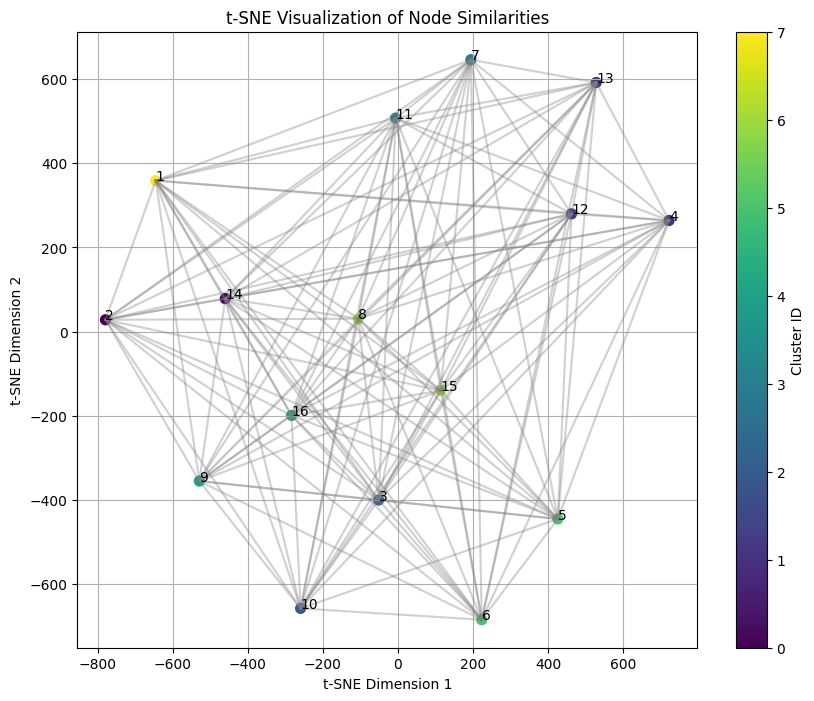

IndexError: index 2 is out of bounds for axis 1 with size 2

IndexError: index 2 is out of bounds for axis 1 with size 2

In [2]:
run 'Step6.ipynb'

# Miserables

In [5]:
nodes,edges,node_list,edge_list,weights = get_data_step6('Datasets/LesMiserables.dot')

In [7]:
def compute_similarity_matrix(node_list, edge_list, weights):
    edge_weights = {(u, v): weight for (u, v), weight in weights.items()}

    num_nodes = len(node_list)
    distances = np.zeros((num_nodes, num_nodes))
    for i, source in enumerate(node_list):
        for j, target in enumerate(node_list):
            if i != j:
                if (source, target) in edge_weights:
                    distances[i, j] = edge_weights[(source, target)]
                elif (target, source) in edge_weights:
                    distances[i, j] = edge_weights[(target, source)]
                else:
                    distances[i, j] = np.inf

    similarities = np.zeros((num_nodes, num_nodes))
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        similarities[i, j] = 1 / (1 + distances[i, j])
        similarities[j, i] = similarities[i, j]  # Similarity matrix is symmetric

    np.fill_diagonal(similarities, 1) #diagonal 1

    return similarities

similarity_matrix = compute_similarity_matrix(node_list, edge_list, weights)

print("Similarity matrix:")
print("\t" + "\t".join(node_list))
for i in range(len(node_list)):
    print(node_list[i], "\t", end="")
    for j in range(len(node_list)):
        print("{:.2f}".format(similarity_matrix[i, j]), "\t", end="")
    print()

similarities = compute_similarity_matrix(node_list, edge_list, weights)


Similarity matrix:
	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	24	25	26	27	28	29	30	32	33	34	35	36	37	38	39	44	45	49	50	52	56	59	65	69	70	71	72	73	17	18	19	20	21	22	23	31	42	43	51	40	41	76	55	46	53	58	63	47	48	60	61	62	64	66	67	74	75	77	57	54	68
1 	1.00 	0.50 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	
2 	0.50 	1.00 	0.11 	0.09 	0.50 	0.50 	0.50 	0.50 	0.33 	0.50 	0.17 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0

Iteration 1: KL divergence = 0.2788119912147522
Iteration 2: KL divergence = 0.2788119912147522
Iteration 3: KL divergence = 0.2788119912147522
Iteration 4: KL divergence = 0.2788119912147522
Iteration 5: KL divergence = 0.2788119912147522
Iteration 6: KL divergence = 0.2788119912147522
Iteration 7: KL divergence = 0.2788119912147522
Iteration 8: KL divergence = 0.2788119912147522
Iteration 9: KL divergence = 0.2788119912147522
Iteration 10: KL divergence = 0.2788119912147522
Iteration 11: KL divergence = 0.2788119912147522
Iteration 12: KL divergence = 0.2788119912147522
Iteration 13: KL divergence = 0.2788119912147522
Iteration 14: KL divergence = 0.2788119912147522
Iteration 15: KL divergence = 0.2788119912147522
Iteration 16: KL divergence = 0.2788119912147522
Iteration 17: KL divergence = 0.2788119912147522
Iteration 18: KL divergence = 0.2788119912147522
Iteration 19: KL divergence = 0.2788119912147522
Iteration 20: KL divergence = 0.2788119912147522
Iteration 21: KL divergence =

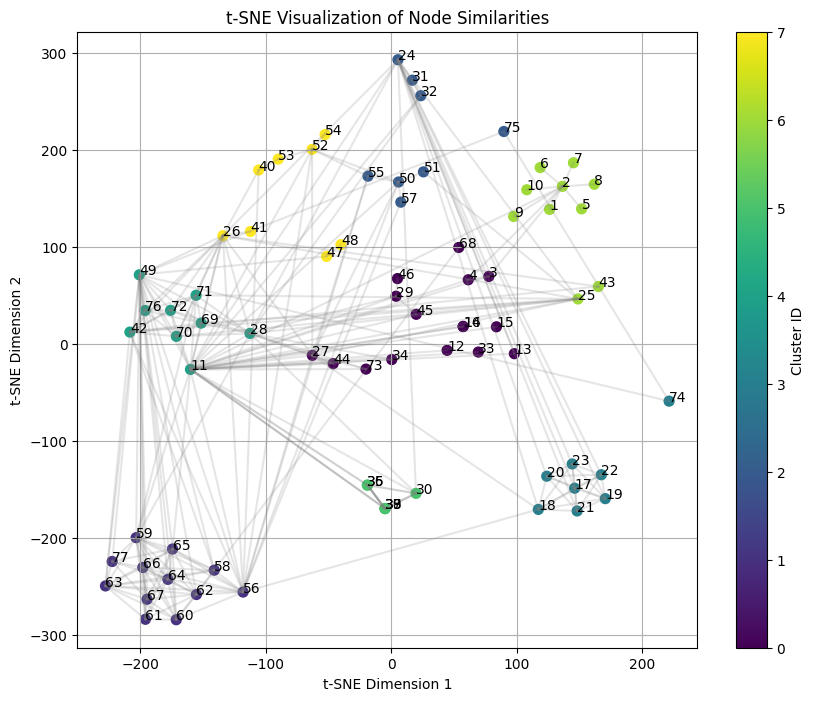

In [11]:
plot_tsne(similarities, node_list, edge_list, perplexity=10, learning_rate=300, n_iter=750, interactive=False)

# Jazz


In [15]:
nodes,edges,node_list,edge_list,weights = get_data_step6('Datasets/JazzNetwork.dot')

print(nodes) 
print(edges)
print(node_list)
print(edge_list)
print(weights)

[<pydot.core.Node object at 0x15464a490>, <pydot.core.Node object at 0x154648c10>, <pydot.core.Node object at 0x14ef599d0>, <pydot.core.Node object at 0x14ef5a390>, <pydot.core.Node object at 0x14ef5bd50>, <pydot.core.Node object at 0x14ef58c50>, <pydot.core.Node object at 0x154c34bd0>, <pydot.core.Node object at 0x154c360d0>, <pydot.core.Node object at 0x154afaf90>, <pydot.core.Node object at 0x14ef5a290>, <pydot.core.Node object at 0x154afbfd0>, <pydot.core.Node object at 0x154766dd0>, <pydot.core.Node object at 0x15600d910>, <pydot.core.Node object at 0x15600c5d0>, <pydot.core.Node object at 0x14ef5ab90>, <pydot.core.Node object at 0x1570488d0>, <pydot.core.Node object at 0x156cd6bd0>, <pydot.core.Node object at 0x156cd5410>, <pydot.core.Node object at 0x155bc8350>, <pydot.core.Node object at 0x155bcb250>, <pydot.core.Node object at 0x155bc8290>, <pydot.core.Node object at 0x155bcb610>, <pydot.core.Node object at 0x1573ee2d0>, <pydot.core.Node object at 0x155c62b50>, <pydot.core.Nod

In [18]:
def compute_similarity_matrix(node_list, edge_list): #no wweights
    num_nodes = len(node_list)
    
    distances = np.full((num_nodes, num_nodes), np.inf)
    
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        distances[i, j] = 1
        distances[j, i] = 1
    
    similarities = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                similarities[i, j] = 1 / (1 + distances[i, j])
    
    np.fill_diagonal(similarities, 1)
    
    return similarities

similarities = compute_similarity_matrix(node_list, edge_list)

print("Similarity matrix:")
print("\t" + "\t".join(node_list))
for i in range(len(node_list)):
    print(node_list[i], "\t", end="")
    for j in range(len(node_list)):
        print("{:.2f}".format(similarities[i, j]), "\t", end="")
    print()



Similarity matrix:
	1	10	11	12	13	14	15	16	17	18	19	2	20	21	22	23	24	3	4	5	6	7	8	9	120	121	122	123	124	125	67	130	145	146	147	148	149	150	157	159	160	101	112	128	133	137	152	164	165	166	167	168	169	170	171	172	173	174	177	178	179	153	155	100	102	103	104	105	106	107	108	109	110	111	116	117	118	119	127	138	139	140	154	191	26	27	28	48	54	55	74	75	76	80	81	83	84	85	86	87	89	90	92	93	95	96	97	98	91	94	134	192	114	158	88	187	188	189	56	135	176	193	126	131	132	31	25	115	144	62	113	35	70	29	30	32	33	143	78	79	141	142	161	180	183	184	34	36	37	42	50	51	52	53	58	60	61	64	65	66	68	69	72	156	181	190	196	38	39	40	41	43	44	45	46	47	57	59	63	71	73	49	185	186	129	136	82	99	151	194	197	182	77	163	198	175	162	195
1 	1.00 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.50 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 	0.00 

Iteration 1: KL divergence = 0.37416213750839233
Iteration 2: KL divergence = 0.37416213750839233
Iteration 3: KL divergence = 0.37416213750839233
Iteration 4: KL divergence = 0.37416213750839233
Iteration 5: KL divergence = 0.37416213750839233
Iteration 6: KL divergence = 0.37416213750839233
Iteration 7: KL divergence = 0.37416213750839233
Iteration 8: KL divergence = 0.37416213750839233
Iteration 9: KL divergence = 0.37416213750839233
Iteration 10: KL divergence = 0.37416213750839233
Iteration 11: KL divergence = 0.37416213750839233
Iteration 12: KL divergence = 0.37416213750839233
Iteration 13: KL divergence = 0.37416213750839233
Iteration 14: KL divergence = 0.37416213750839233
Iteration 15: KL divergence = 0.37416213750839233
Iteration 16: KL divergence = 0.37416213750839233
Iteration 17: KL divergence = 0.37416213750839233
Iteration 18: KL divergence = 0.37416213750839233
Iteration 19: KL divergence = 0.37416213750839233
Iteration 20: KL divergence = 0.37416213750839233
Iteration

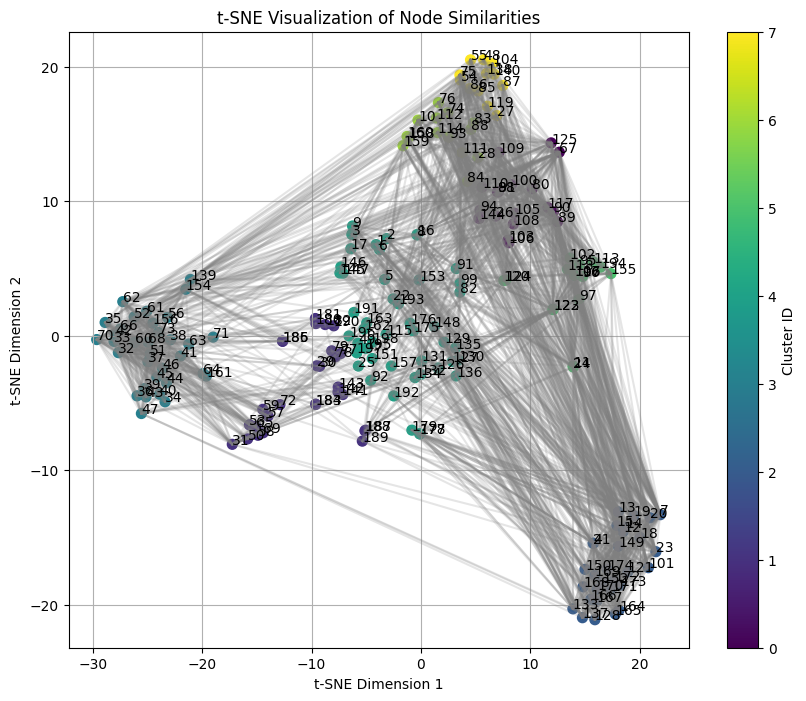

In [20]:
plot_tsne(similarities, node_list, edge_list, perplexity=20, learning_rate=300, n_iter=750, interactive=False)

# League

In [22]:
nodes,edges,node_list,edge_list,weights = get_data_league('Datasets/LeagueNetwork.dot')

print(nodes) 
print(edges)
print(node_list)
print(edge_list)
print(weights)

[<pydot.core.Node object at 0x15c4a1290>, <pydot.core.Node object at 0x15c4a2690>, <pydot.core.Node object at 0x161f7a3d0>, <pydot.core.Node object at 0x159862690>, <pydot.core.Node object at 0x159860c10>, <pydot.core.Node object at 0x1598637d0>, <pydot.core.Node object at 0x1598d3e10>, <pydot.core.Node object at 0x15981e190>, <pydot.core.Node object at 0x15981f650>, <pydot.core.Node object at 0x159860950>, <pydot.core.Node object at 0x15992e850>, <pydot.core.Node object at 0x15992e4d0>, <pydot.core.Node object at 0x1597fc190>, <pydot.core.Node object at 0x1598fc890>, <pydot.core.Node object at 0x1598fd310>, <pydot.core.Node object at 0x15979d450>]
[<pydot.core.Edge object at 0x159677c50>, <pydot.core.Edge object at 0x159675b50>, <pydot.core.Edge object at 0x1598c9fd0>, <pydot.core.Edge object at 0x159954710>, <pydot.core.Edge object at 0x159955ad0>, <pydot.core.Edge object at 0x1599a1ad0>, <pydot.core.Edge object at 0x15996fd90>, <pydot.core.Edge object at 0x1599170d0>, <pydot.core.Ed

In [24]:
def compute_similarity_matrix_league(node_list, edge_list, weights):
    edge_weights = {(u, v): weight for (u, v), weight in weights.items()}

    num_nodes = len(node_list)
    distances = np.zeros((num_nodes, num_nodes))
    for i, source in enumerate(node_list):
        for j, target in enumerate(node_list):
            if i != j:
                if (source, target) in edge_weights:
                    distances[i, j] = edge_weights[(source, target)]
                elif (target, source) in edge_weights:
                    distances[i, j] = -edge_weights[(target, source)]  # Taking negative to convert goal difference to distance
                else:
                    distances[i, j] = np.inf

    similarities = np.zeros((num_nodes, num_nodes))
    for u, v in edge_list:
        i = node_list.index(u)
        j = node_list.index(v)
        similarities[i, j] = 1 / (1 + abs(distances[i, j]))  # Taking absolute value of distance
        similarities[j, i] = similarities[i, j]  # Similarity matrix is symmetric

    np.fill_diagonal(similarities, 1)  # Diagonal set to 1

    return similarities

similarities = compute_similarity_matrix_league(node_list, edge_list, weights)

print("Similarity matrix:")
print("\t" + "\t".join(node_list))
for i in range(len(node_list)):
    print(node_list[i], "\t", end="")
    for j in range(len(node_list)):
        print("{:.2f}".format(similarities[i, j]), "\t", end="")
    print()

Similarity matrix:
	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16
1 	1.00 	1.00 	0.33 	0.50 	0.50 	1.00 	0.50 	0.50 	0.25 	0.50 	0.33 	0.25 	0.50 	0.50 	0.50 	0.25 	
2 	1.00 	1.00 	0.50 	0.33 	0.25 	0.50 	0.33 	0.33 	0.50 	1.00 	0.50 	0.50 	0.50 	1.00 	0.33 	1.00 	
3 	0.33 	0.50 	1.00 	0.33 	0.50 	1.00 	1.00 	1.00 	1.00 	1.00 	0.33 	0.33 	0.50 	0.33 	1.00 	0.50 	
4 	0.50 	0.33 	0.33 	1.00 	0.14 	0.50 	0.25 	0.50 	0.33 	0.25 	0.50 	1.00 	1.00 	0.25 	0.20 	0.50 	
5 	0.50 	0.25 	0.50 	0.14 	1.00 	1.00 	0.33 	0.50 	1.00 	0.50 	0.50 	0.50 	0.50 	0.25 	0.20 	0.50 	
6 	1.00 	0.50 	1.00 	0.50 	1.00 	1.00 	0.50 	0.50 	0.25 	1.00 	0.50 	0.20 	0.33 	0.33 	0.50 	0.33 	
7 	0.50 	0.33 	1.00 	0.25 	0.33 	0.50 	1.00 	1.00 	0.25 	0.50 	1.00 	0.50 	1.00 	0.50 	0.25 	0.50 	
8 	0.50 	0.33 	1.00 	0.50 	0.50 	0.50 	1.00 	1.00 	1.00 	1.00 	0.50 	0.50 	0.50 	1.00 	1.00 	1.00 	
9 	0.25 	0.50 	1.00 	0.33 	1.00 	0.25 	0.25 	1.00 	1.00 	0.50 	0.50 	0.50 	0.50 	1.00 	1.00 	1.00 	
10 	0.50 	1.00 	1.00 	0.25 	0.50 	1.00 	0

Iteration 1: KL divergence = 0.15094587206840515
Iteration 2: KL divergence = 0.15094587206840515
Iteration 3: KL divergence = 0.15094587206840515
Iteration 4: KL divergence = 0.15094587206840515
Iteration 5: KL divergence = 0.15094587206840515
Iteration 6: KL divergence = 0.15094587206840515
Iteration 7: KL divergence = 0.15094587206840515
Iteration 8: KL divergence = 0.15094587206840515
Iteration 9: KL divergence = 0.15094587206840515
Iteration 10: KL divergence = 0.15094587206840515
Iteration 11: KL divergence = 0.15094587206840515
Iteration 12: KL divergence = 0.15094587206840515
Iteration 13: KL divergence = 0.15094587206840515
Iteration 14: KL divergence = 0.15094587206840515
Iteration 15: KL divergence = 0.15094587206840515
Iteration 16: KL divergence = 0.15094587206840515
Iteration 17: KL divergence = 0.15094587206840515
Iteration 18: KL divergence = 0.15094587206840515
Iteration 19: KL divergence = 0.15094587206840515
Iteration 20: KL divergence = 0.15094587206840515
Iteration

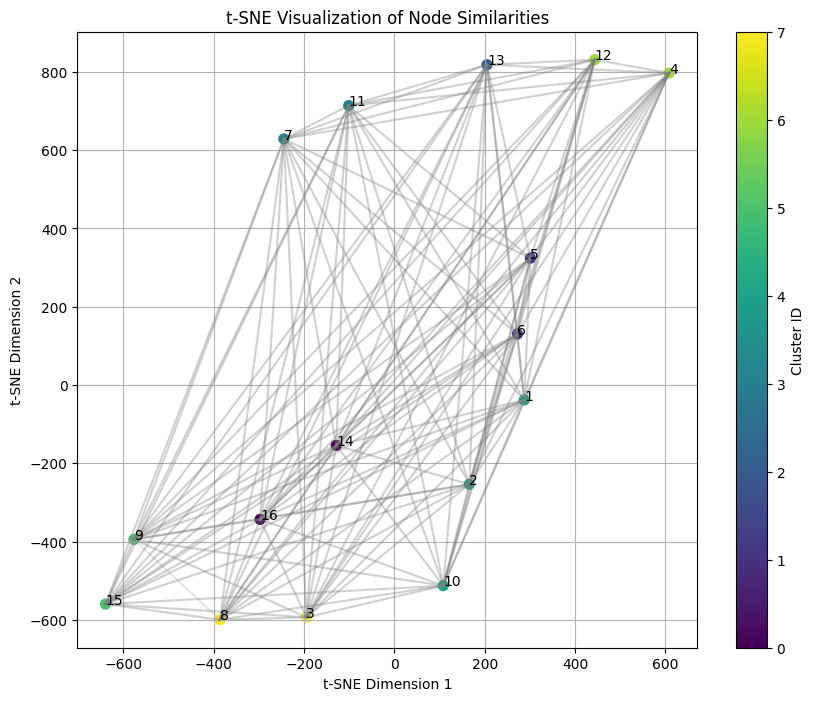

In [27]:
plot_tsne(similarities, node_list, edge_list, perplexity=5, learning_rate=300, n_iter=750, interactive=False)